# The Universal Approximator


"We show that multilayer feedforward networks with as few as one hidden layer are indeed capable of **universal approximation in a very precise and satisfactory way.**" (Hornick et. al, 1989, p.359)

"[...] any continous function can be uniformly approximated by a continous neural network having only one internal hidden layer and with an arbitraty continous sigmoidal nonlinearity" (Cybenko, 1989, p. 312)


"The approximation properties of feed-forward networks have been widely studied (Funahashi, 1989; Cybenko, 1989; Hornik et al., 1989; Stinchecombe and White, 1989; Cotter, 1990; Ito, 1991; Hornik, 1991; Kreinovich, 1991; Ripley, 1996) and found to be very general. **Neural networks are therefore said to be universal approximators**. For example, a two-layer network with linear outputs can uniformly approximate any continuous function on a compact input domain to arbitrary accuracy provided the network has a sufficiently large number of hidden units. This result holds for a wide range of hidden unit activation functions, but excluding polynomials." (Bishop, 2006, p. 230)

# Introduction

The purpose of this notebook is to experimentally explore the theoretical findings of *Hornit et al. (1989)* and *Cybenko (1989)* regarding the capacity of neural networks to approximate arbitrarily well any given function. This will be done firstly by trying to approximate six different one dimensional functions with a simple *Feed Forward Neural Network (FFNN)* with one hidden layer and three units. We will then increase the number of units to understand how the quality of the approximation changes.

On more practical matters, this notebook also has the purpose of exploring the tools *PyTorch* provides to implement FFNN and understand the different complexities that arrive when trainning these networks; especially the ones related to local minima.

# Set-up

We will start by introducing more formally (although not extensively) the statement of universal approximation mainly following the work from Cybenko (1989). Afterwards we will introduce some of the basic functions that will serve as the basis for our experimentation.

## Universal approximation

As Cybenko (1989) states "networks with one internal layer and an arbitrary continous sigmoidal function can approximate continous functions with arbitrary precision providing that no constraints are placed on the number of nodes or the size of the weights". This statement is consolidated in the second theorem of his paper (replicated below).

**Theorem 2.** Let $ \sigma $ be any continous sigmoidal function. Then finite sums of the form:

\begin{equation*}
G(x) = \sum_{j = 1}^{N} \alpha_j \sigma (y_j^{T}x + \theta_j)
\end{equation*}

Given any $f \in C(I_n)$ and $\varepsilon > 0$, there is a sum $G(x)$ of the above form for which

\begin{equation*}
\mid G(x) - f(x) \mid < \varepsilon
\text{     for all  } x \in I_n
\end{equation*}

***
Where $I_n$ corresponds to the n-dimensional unit cube and $C(I_n)$ corresponds to the space of continous functions in $I_n$

## Function definitions

We will start by defining some basic functions that we will later try to approximate using a simple FFNN.

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

In [187]:
# a classic step-wise function
def piecewise_simple(x): 
    return(np.piecewise(x, [x < 0, x >= 0], [-1, 1]))

# a more complicated step-wise function
def piecewise_comp(x): 
    return(np.piecewise(x, [x < 0, x >= 0], [lambda x: np.cos(x), lambda x: x]))

# absolute value function
def abs_value(x): 
    return(np.piecewise(x, [x < 0, x >= 0], [lambda x: -x, lambda x: x]))

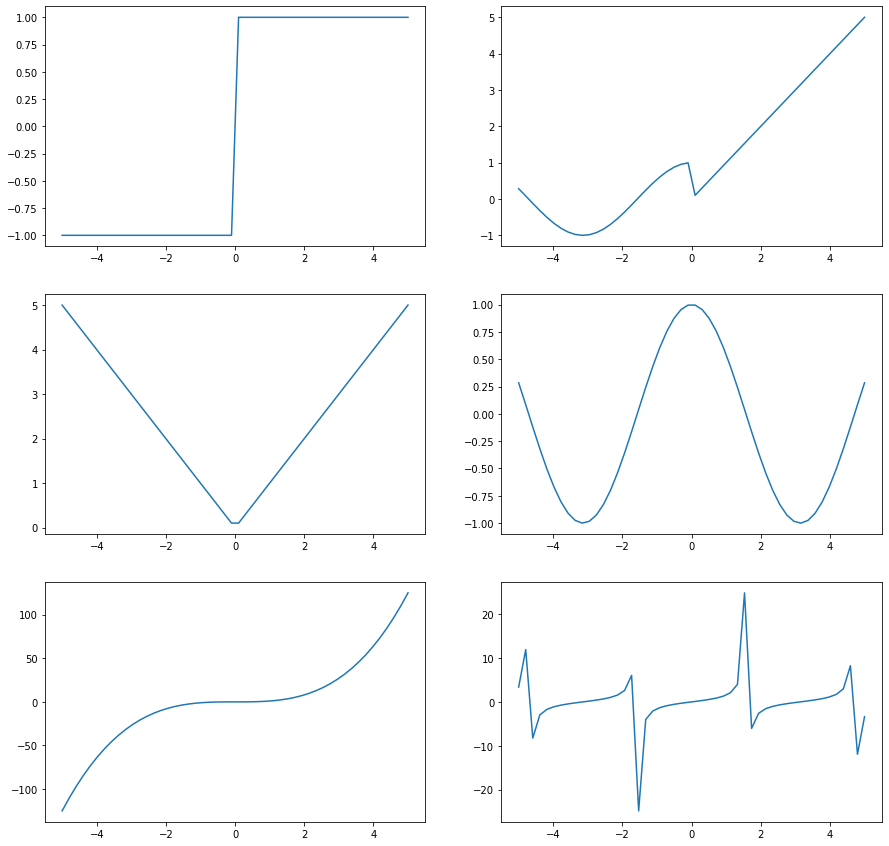

In [228]:
x = np.linspace(-5, 5, 50)

y_pw1 = piecewise_simple(x)
y_pw2 = piecewise_comp(x)
y_abs = abs_value(x)
y_cos = np.cos(x)
y_cube = x**3
y_t = np.tan(x)

fig, ax = plt.subplots(3, 2, )
fig.set_size_inches(15, 15)
ax[0][0].plot(x,y_pw1)
ax[0][1].plot(x,y_pw2)
ax[1][0].plot(x,y_abs)
ax[1][1].plot(x,y_cos)
ax[2][0].plot(x,y_cube)
ax[2][1].plot(x,y_t)

plt.show()

In [189]:
# We would also need a function that transforms numpy arrays into Tensors
def get_tensors(x,y):
    X = torch.FloatTensor(x)
    Y = torch.FloatTensor(y)
    device = torch.device("cpu")
    X.to(device)
    Y.to(device)
    
    return (X,Y)

# Building a simple Feed Forward Neural Network

We will now use the tools provided by *PyTorch* to implement a FFNN with one hidden layer. We explicitly implement each of the elements of the FFNN for more clarity and learning purposes. The use of *PyTorch* is very convenient because of its capacity to handle the gradients of the network.

In [190]:
class MyNN(torch.nn.Module):
    def __init__(self, dim_in, hidden_units):
        super(MyNN, self).__init__()
        
        # Define the functions we will use for the layers>
        
        # 1. linear combination of the inputs
        self.linear1 = torch.nn.Linear(dim_in, hidden_units)
        # 2. Activation function. We use Sigmoid to follow Cybenko (1989)
        self.activation1 = torch.nn.Sigmoid()
        # 3. Linear combination of the activation functions
        self.linear2 = torch.nn.Linear(hidden_units, 1)
        
        # Define the loss function
        self.loss_function = torch.nn.MSELoss(reduction='sum')
        
    def forward(self, x):
        # Pass the input tensor through each of the layers
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        return x
    
    def loss(self,pred,y):
        return self.loss_function(pred,y)

In [191]:
# Define a function for setting in motion the training of the FFNN
def training(X,Y, model,optimizer,epochs):
    # empty list to store the loss at each epoch
    losses = []
    for epoch in range(epochs):
        
        # Start by getting predictions
        y_pred = model(X.view(-1,1))
        
        # Calculate the loss
        loss = model.loss(y_pred,Y.view(-1,1))

        # Zero all of the gradients
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        # Some optional visualization of the process
        #print('Loss: ', loss.data.cpu().numpy())
        
        # Storing the losses
        losses.append(loss)
        
    # Get predictions
    y_pred = model(X.view(-1,1))
    # Transform Tensor into a list
    y_pred = [y.data.cpu().numpy()[0] for y in y_pred]
    
    return y_pred, losses

# Performance test

Now that we have defined our FFNN and its training procedure we can understand its performance to approximate the one dimensional functions we introduced earlier.

In [192]:
# Initialize the model
model = MyNN(dim_in = 1, hidden_units = 3)

# We need to define the Optimizer we will use for our FFNN.
# For the purpose of this experimentation we will use 
# Stochastic Gradient Descent (SGD)
learning_rate = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [193]:
# generate random X data
x = np.linspace(-5, 5, 50)

# transform data into tensors
X,Y_pw1 = get_tensors(x,y_pw1)
X,Y_pw2 = get_tensors(x,y_pw2)
X,Y_abs = get_tensors(x,y_abs)
X,Y_cos = get_tensors(x,y_cos)
X,Y_cube = get_tensors(x,y_cube)
X,Y_t = get_tensors(x,y_t)

In [194]:
# define the number of epochs for the training of the models
epochs = 300

# get predictions for each function
y_pred_pw1, loss_pw1 = training(X,Y_pw1,model,optimizer,epochs)
y_pred_pw2, loss_pw2 = training(X,Y_pw2,model,optimizer,epochs)
y_pred_abs, loss_abs = training(X,Y_abs,model,optimizer,epochs)
y_pred_cos, loss_cos = training(X,Y_cos,model,optimizer,epochs)
y_pred_cube, loss_cube = training(X,Y_cube,model,optimizer,epochs)
y_pred_t, loss_t = training(X,Y_t,model,optimizer,epochs)

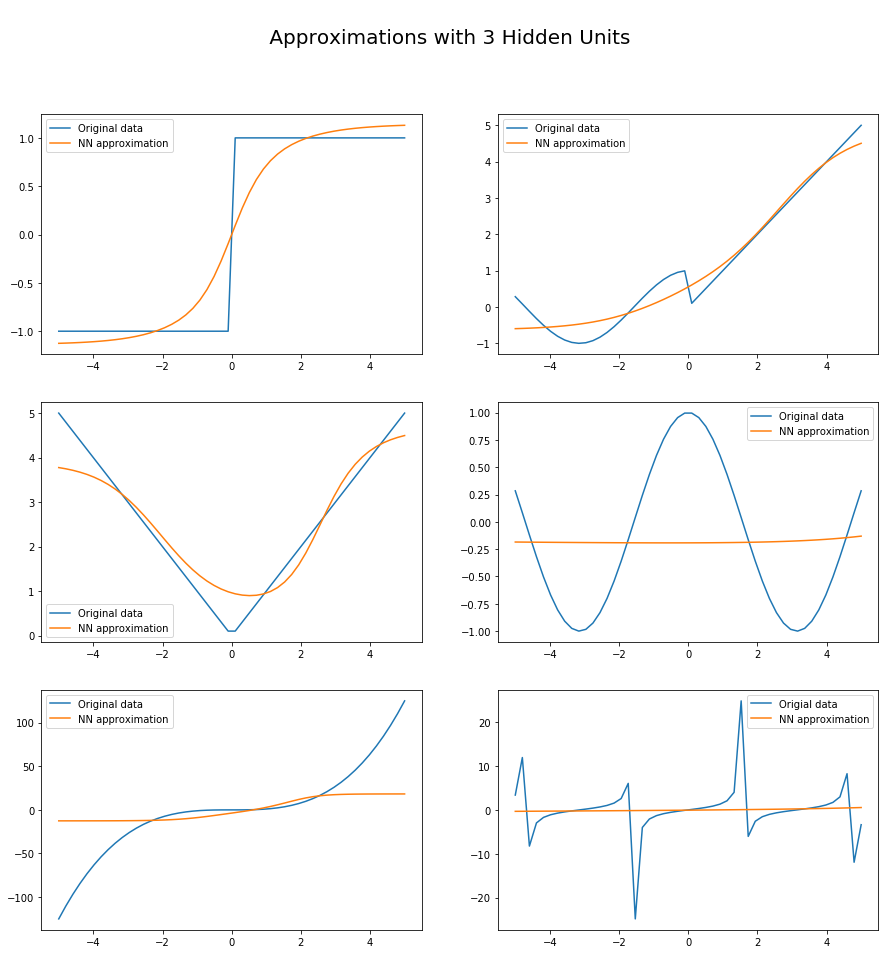

In [195]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)

ax[0][0].plot(x,y_pw1, label = "Original data")
ax[0][0].plot(x,y_pred_pw1, label = 'NN approximation')
ax[0][0].legend()

ax[0][1].plot(x,y_pw2, label = "Original data")
ax[0][1].plot(x,y_pred_pw2, label = "NN approximation")
ax[0][1].legend()

ax[1][0].plot(x,y_abs, label = "Original data")
ax[1][0].plot(x,y_pred_abs, label = "NN approximation")
ax[1][0].legend()

ax[1][1].plot(x,y_cos, label = "Original data")
ax[1][1].plot(x,y_pred_cos, label = "NN approximation")
ax[1][1].legend()

ax[2][0].plot(x,y_cube, label = "Original data")
ax[2][0].plot(x,y_pred_cube, label = "NN approximation")
ax[2][0].legend()

ax[2][1].plot(x,y_t, label = "Origial data")
ax[2][1].plot(x,y_pred_t, label = "NN approximation")
ax[2][1].legend()

fig.suptitle("\n Approximations with 3 Hidden Units", fontsize=20)
plt.show()

These first results show that our FFNN with only 3 hidden units is capable of creating reasonable approximations to the first three functions. For the last 3 functions the FFNN has much more problems. In these cases, the approximation made by the FFNN is very similar to a flat line. To get some more understanding of these results we will also explore the transition of the losses through the epochs.

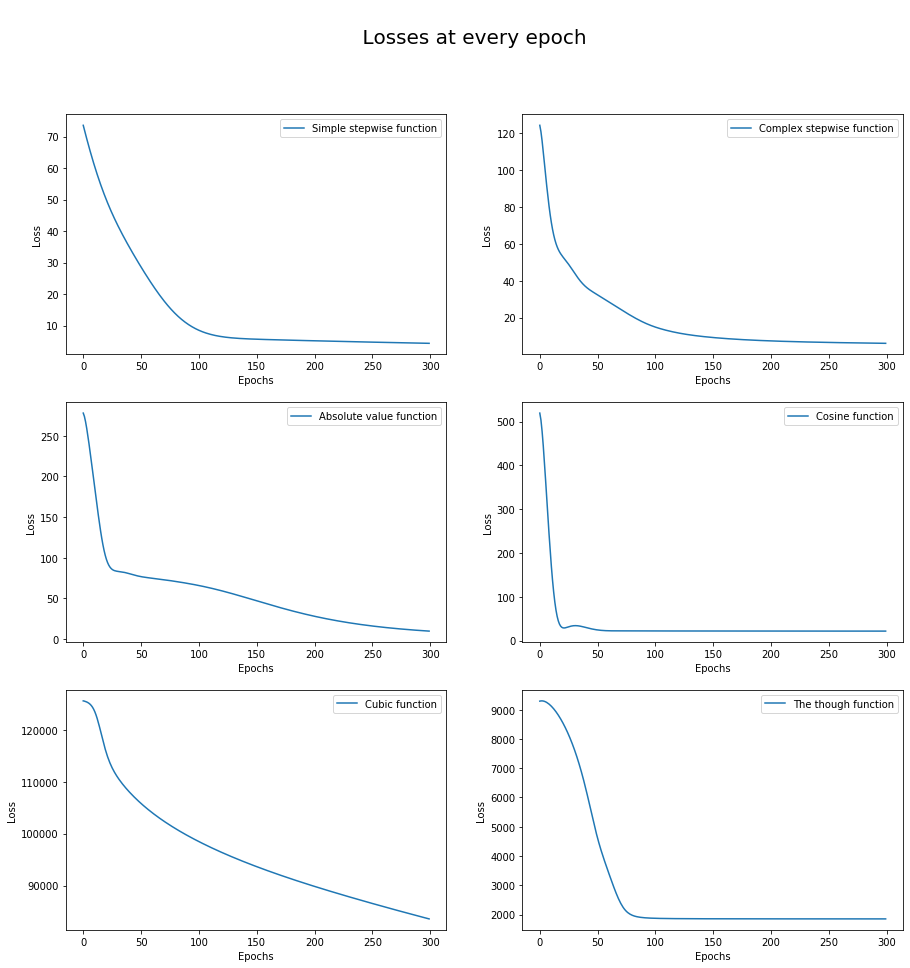

In [202]:
# plot the loss function for each function
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)

ax[0][0].plot(list(range(epochs)),loss_pw1, label = "Simple stepwise function")
ax[0][0].legend()
ax[0][0].set_xlabel('Epochs')
ax[0][0].set_ylabel('Loss')

ax[0][1].plot(list(range(epochs)),loss_pw2, label = "Complex stepwise function")
ax[0][1].legend()
ax[0][1].set_xlabel('Epochs')
ax[0][1].set_ylabel('Loss')

ax[1][0].plot(list(range(epochs)),loss_abs, label = "Absolute value function")
ax[1][0].legend()
ax[1][0].set_xlabel('Epochs')
ax[1][0].set_ylabel('Loss')

ax[1][1].plot(list(range(epochs)),loss_cos, label = "Cosine function")
ax[1][1].legend()
ax[1][1].set_xlabel('Epochs')
ax[1][1].set_ylabel('Loss')

ax[2][0].plot(list(range(epochs)),loss_cube, label = "Cubic function")
ax[2][0].legend()
ax[2][0].set_xlabel('Epochs')
ax[2][0].set_ylabel('Loss')

ax[2][1].plot(list(range(epochs)),loss_t, label = "The though function")
ax[2][1].legend()
ax[2][1].set_xlabel('Epochs')
ax[2][1].set_ylabel('Loss')

fig.suptitle("\n Losses at every epoch", fontsize=20)
plt.show()

Looking at the plot of the loss through the epochs shows that in all cases the FFNN is learning; the loss is effectively decreasing with time. However, it is also clear that for some functios the loss at which the FFNN converges is far from zero. It is interesting to see that most of the losses seem to be converging even though some of the FFNN are doing a considerably bad job at approximating the function. This could be the sign of a local minima. 

# Some more functions for experimentation

Now that we have seen the algorithm ( 1. defining the model, 2. defining the loss and 3. defining the optimization method) in action it is very convenient to wrap-up the whole experimentation process into functions so that we can easily change the relevant parameters and observer the results of these changes.

In [203]:
def multiple_functions(model, optimizer, epochs):

    x = np.linspace(-5, 5, 50)

    # generate training data for all functions
    y_pw1 = piecewise_simple(x)
    y_pw2 = piecewise_comp(x)
    y_abs = abs_value(x)
    y_cos = np.cos(x)
    y_cube = x**3
    y_t = np.tan(x)

    # transform data into tensors
    X,Y_pw1 = get_tensors(x,y_pw1)
    X,Y_pw2 = get_tensors(x,y_pw2)
    X,Y_abs = get_tensors(x,y_abs)
    X,Y_cos = get_tensors(x,y_cos)
    X,Y_cube = get_tensors(x,y_cube)
    X,Y_t = get_tensors(x,y_t)

    # create a list of all Y data to loop over
    #Y_all = [Y_pw1, Y_pw2, Y_abs, Y_cos, Y_cube, Y_t] 

    # get predictions for each function
    y_pred_pw1, loss_pw1 = training(X,Y_pw1,model,optimizer,epochs)
    y_pred_pw2, loss_pw2 = training(X,Y_pw2,model,optimizer,epochs)
    y_pred_abs, loss_abs = training(X,Y_abs,model,optimizer,epochs)
    y_pred_cos, loss_cos = training(X,Y_cos,model,optimizer,epochs)
    y_pred_cube, loss_cube = training(X,Y_cube,model,optimizer,epochs)
    y_pred_t, loss_t = training(X,Y_t,model,optimizer,epochs)

    # list to return the original y data (not in tensor form)
    y_all = [y_pw1, y_pw2, y_abs, y_cos, y_cube, y_t]

    # list to return the predictions made
    Y_pred = [y_pred_pw1, y_pred_pw2, y_pred_abs, y_pred_cos, y_pred_cube, y_pred_t] 


    return {'x': x, 'original': y_all ,'predictions': Y_pred}


def plot_results(results, title):

    fig, ax = plt.subplots(3, 2)
    fig.set_size_inches(15, 15)
    
    fig.suptitle(title, fontsize=20)
    
    ax[0][0].plot(results['x'],results['original'][0], label = "Original data")
    ax[0][0].plot(results['x'],results['predictions'][0], label = 'NN approximation')
    ax[0][0].legend()

    ax[0][1].plot(results['x'],results['original'][1], label = "Original data")
    ax[0][1].plot(results['x'],results['predictions'][1], label = "NN approximation")
    ax[0][1].legend()

    ax[1][0].plot(results['x'],results['original'][2], label = "Original data")
    ax[1][0].plot(results['x'],results['predictions'][2], label = "NN approximation")
    ax[1][0].legend()

    ax[1][1].plot(results['x'],results['original'][3], label = "Original data")
    ax[1][1].plot(results['x'],results['predictions'][3], label = "NN approximation")
    ax[1][1].legend()

    ax[2][0].plot(results['x'],results['original'][4], label = "Original data")
    ax[2][0].plot(results['x'],results['predictions'][4], label = "NN approximation")
    ax[2][0].legend()

    ax[2][1].plot(results['x'],results['original'][5], label = "Original data")
    ax[2][1].plot(results['x'],results['predictions'][5], label = "NN approximation")
    ax[2][1].legend()

    return fig

# Increasing the number of hidden units

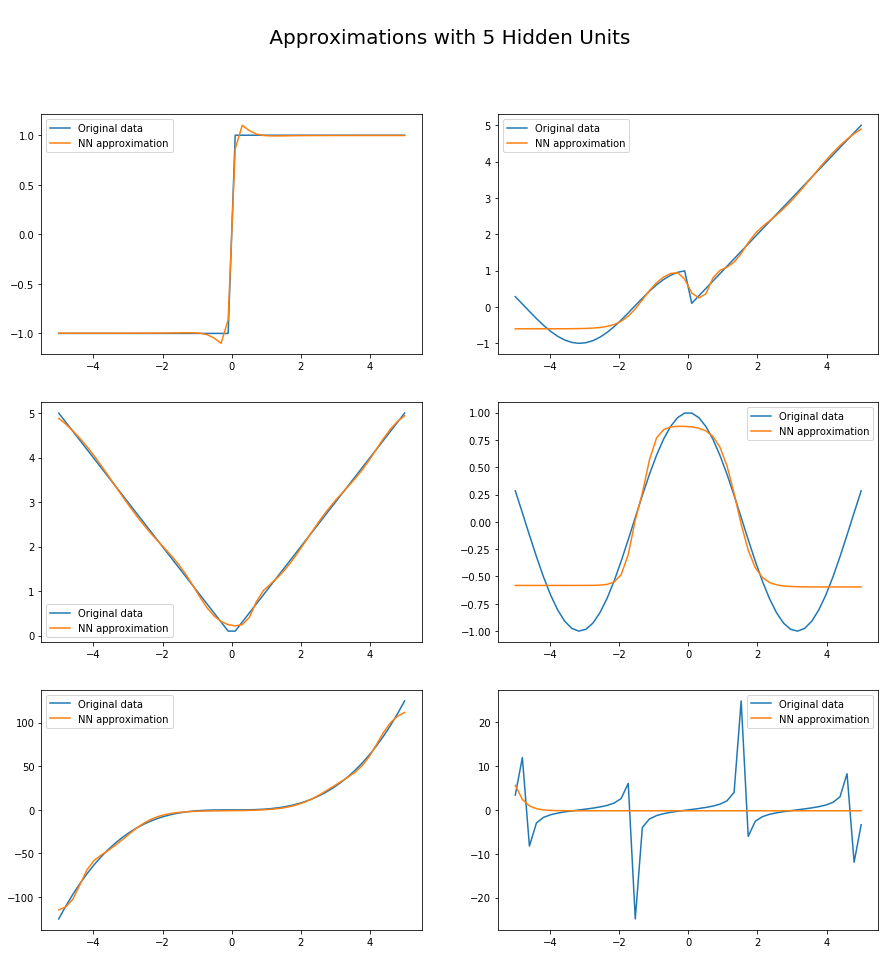

In [204]:
dim_in = 1 
hidden_units = 5
epochs = 500


# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)

learning_rate = 0.0015
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

results5 = multiple_functions(model, optimizer, epochs)
my_plot = plot_results(results5, "\n Approximations with 5 Hidden Units")

Impressively, with just 5 hidden units the FFNN is able to generate a very satisfactory approximation of almost all the functions.

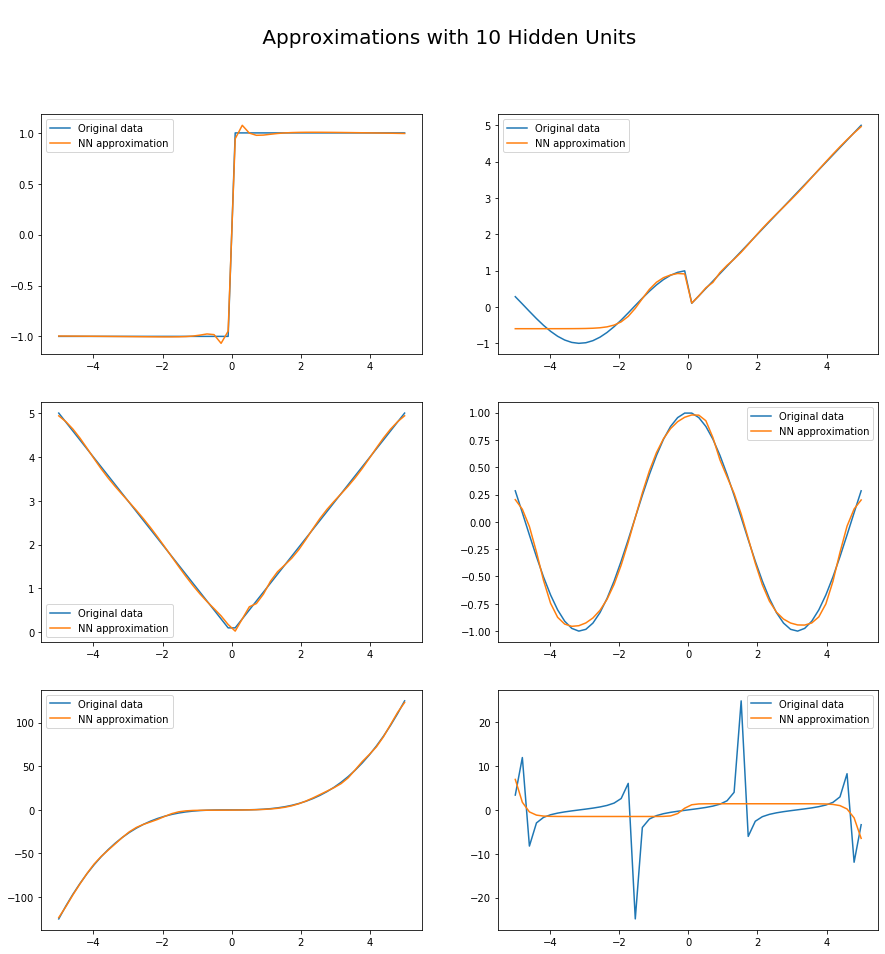

In [205]:
dim_in = 1 
hidden_units = 10
epochs = 500

# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)

learning_rate = 0.0015
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

results10 = multiple_functions(model, optimizer, epochs)
my_plot = plot_results(results10, "\n Approximations with 10 Hidden Units")

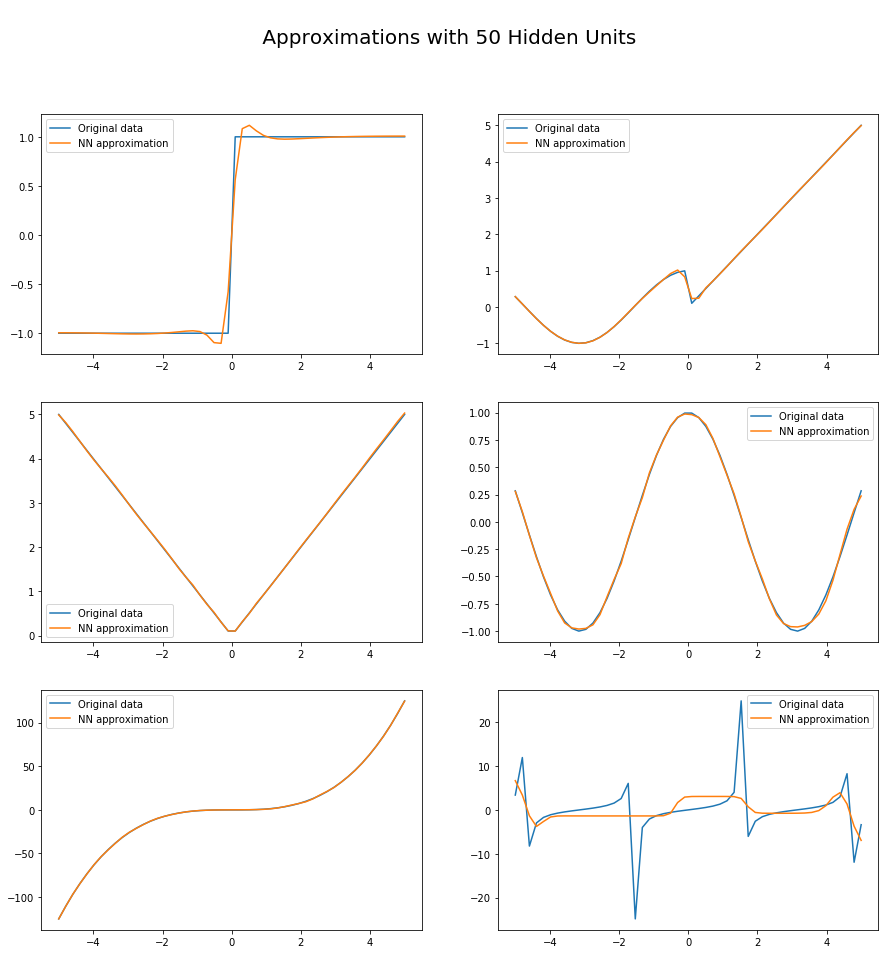

In [206]:
dim_in = 1 
hidden_units = 50
epochs = 500

# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)

learning_rate = 0.00005
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

results50 = multiple_functions(model, optimizer, epochs)
my_plot = plot_results(results50, "\n Approximations with 50 Hidden Units")

At this stage we have a very good approximationo to all functions except for the last one. Lets try to keeo increasing the number of units until we get a reasonable approximation.

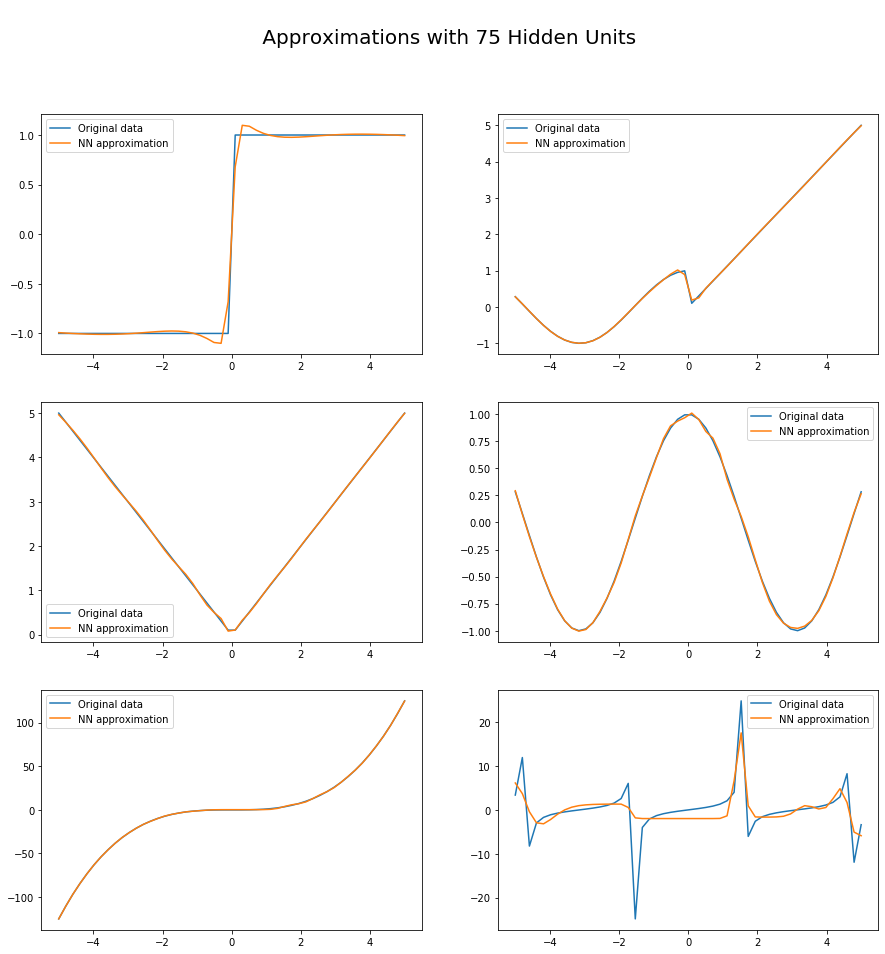

In [207]:
dim_in = 1 
hidden_units = 75
epochs = 500

# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)

learning_rate = 0.0015
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

results75 = multiple_functions(model, optimizer, epochs)
my_plot = plot_results(results75, "\n Approximations with 75 Hidden Units")

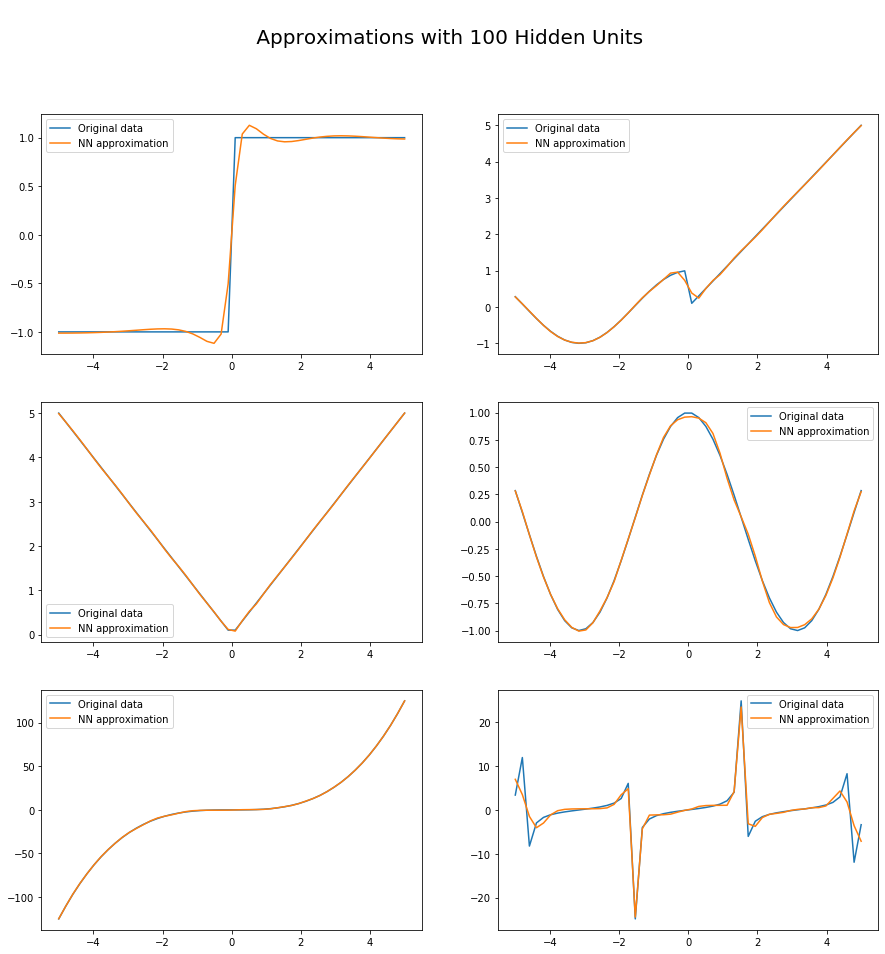

In [208]:
dim_in = 1 
hidden_units = 100
epochs = 500

# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)

learning_rate = 0.0015
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

results100 = multiple_functions(model, optimizer, epochs)
my_plot = plot_results(results100, "\n Approximations with 100 Hidden Units")

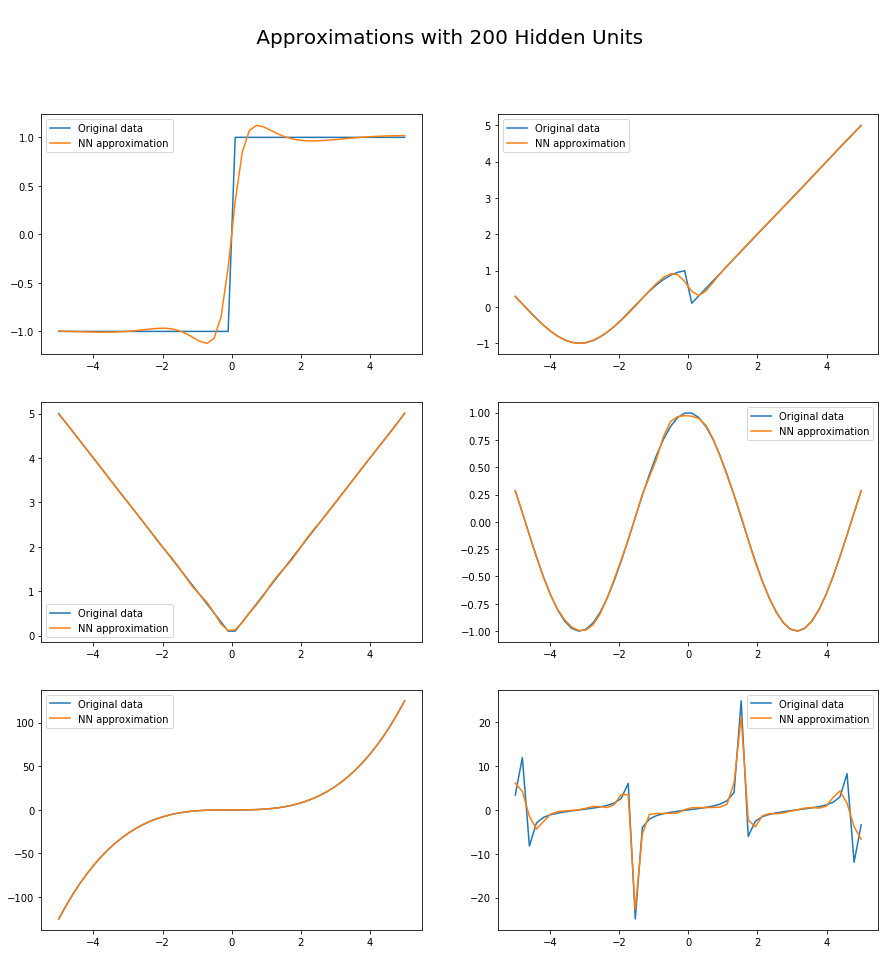

In [212]:
dim_in = 1 
hidden_units = 200
epochs = 500

# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)

learning_rate = 0.0015
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

results200 = multiple_functions(model, optimizer, epochs)
my_plot = plot_results(results200, "\n Approximations with 200 Hidden Units")

# The tough cookie

Given that the last function was the one for which the FFNN required more hidden units in order to produce a succesfull approximation, it is interesting to observe this process with greater detail. Below, we will see the approximation that the FFNN was producing at every stage.

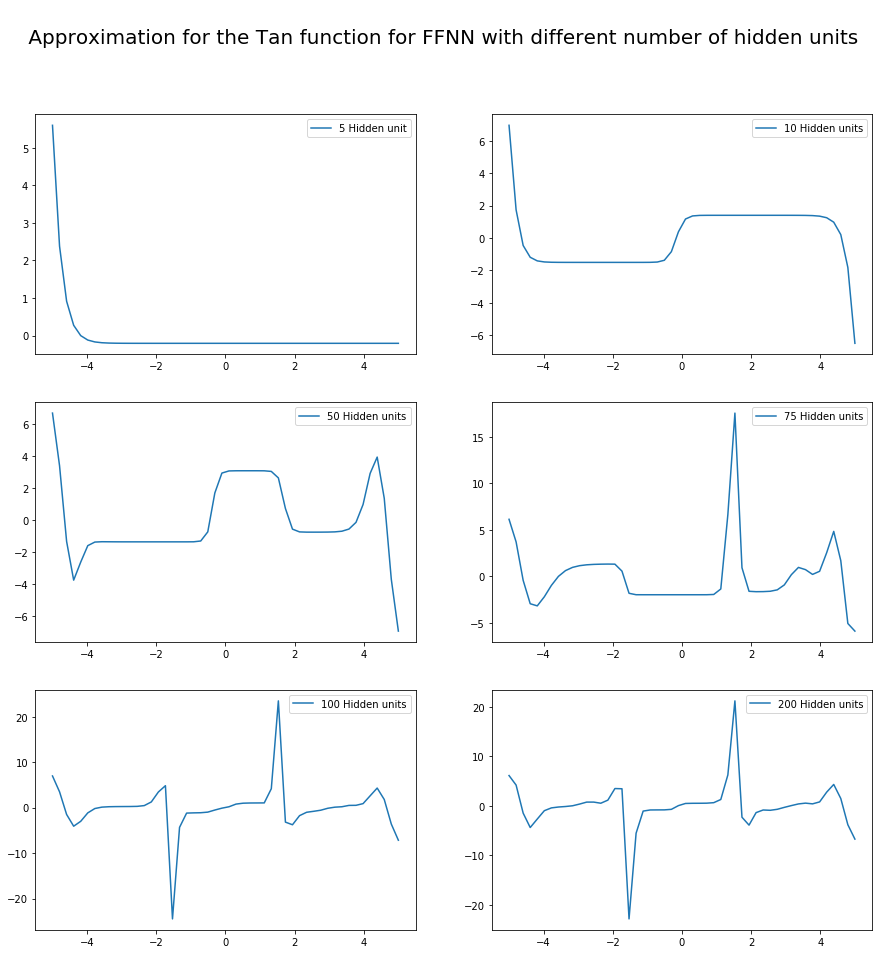

In [213]:
# plot the loss function for each function
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15, 15)

ax[0][0].plot(results5['x'],results5['predictions'][5], label = "5 Hidden unit")
ax[0][0].legend()

ax[0][1].plot(results10['x'],results10['predictions'][5], label = "10 Hidden units")
ax[0][1].legend()

ax[1][0].plot(results50['x'],results50['predictions'][5], label = "50 Hidden units")
ax[1][0].legend()

ax[1][1].plot(results75['x'],results75['predictions'][5], label = "75 Hidden units")
ax[1][1].legend()

ax[2][0].plot(results100['x'],results100['predictions'][5], label = "100 Hidden units")
ax[2][0].legend()

ax[2][1].plot(results200['x'],results200['predictions'][5], label = "200 Hidden units")
ax[2][1].legend()

fig.suptitle("\n Approximation for the Tan function for FFNN with different number of hidden units", fontsize=20)
plt.show()

# The difficulties of trainning a FFNN

Lastly, we will show how different runs of the SGD algorithm (with the same hyperparameters) produce different approximations. 

In [244]:
dim_in = 1 
hidden_units = 50
epochs = 300

# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)
learning_rate = 0.3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
results50a = multiple_functions(model, optimizer, epochs)

In [245]:
# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)
learning_rate = 0.3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
results50b = multiple_functions(model, optimizer, epochs)

In [246]:
# Initialize the FFNN with the given parameters
model = MyNN(dim_in = dim_in, hidden_units = hidden_units)
learning_rate = 0.3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
results50c = multiple_functions(model, optimizer, epochs)

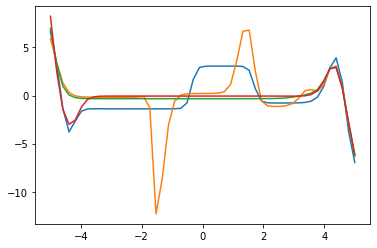

In [247]:
plt.plot(results50['x'],results50['predictions'][5])
plt.plot(results50['x'],results50a['predictions'][5])
plt.plot(results50['x'],results50b['predictions'][5])
plt.plot(results50['x'],results50c['predictions'][5])
plt.show()

Quickly putting the approximations together we can see that they have notorious difference with each other. We will build a new plot that allows for a more clear visualization.

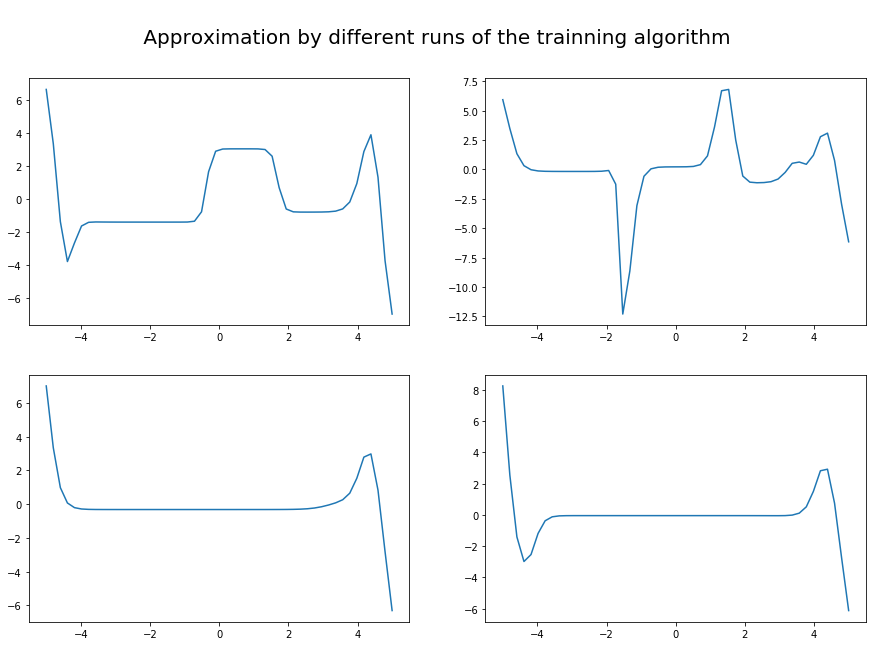

In [248]:
# plot the loss function for each function
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 10)

ax[0][0].plot(results50['x'],results50['predictions'][5])

ax[0][1].plot(results50a['x'],results50a['predictions'][5])

ax[1][0].plot(results50b['x'],results50b['predictions'][5])

ax[1][1].plot(results50c['x'],results50c['predictions'][5])

fig.suptitle("\n Approximation by different runs of the trainning algorithm", fontsize=20)
plt.show()

It is interesting to see how different the approximations are even though they were learned by a FFNN with the same structure. This portraits some of the complexities and subtleties of trainning these networks.